In [32]:
# DO NOT FORGET TO MAKE THE DATASET PRIVATE
# TRASH : few symbol texts
# only whitespaces
# Need too deal with languages : All to ENG
# Need to use the ORG feature as a textual feature OR as a clustering

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# В поле data можете заметить такие данные как *, $$$$$, #####.

# "******" - ФИО
# "$$$$$" - IBAN счет
# "#####" - ИИН, БИН

# LANGUAGE_CODE
# 1 - KZ
# 2 - RU
# 3 - ENG
# Но возможны не правильно определенные данные, нужно проверить и почистить

In [2]:
dept = pd.read_csv('/kaggle/input/d/nurlybek17/datasaur2-2/dictionaries_categories.csv', index_col=0)
org = pd.read_csv('/kaggle/input/d/nurlybek17/datasaur2-2/dictionary_org.csv', index_col=0)
train_df = pd.read_csv('/kaggle/input/d/nurlybek17/datasaur2-2/train_category.csv', index_col=0)
test_df = pd.read_csv('/kaggle/input/d/nurlybek17/datasaur2-2/category_test_final.csv', index_col=0)

In [36]:
# join train with label names
train_df = pd.merge(train_df, dept, left_on='target', right_on='id')

In [76]:
train_df.head(10)

,ID,target,DATA,LANGUAGE_CODE,APPEAL_FORM,ORG_ID,id,name_ru,name_kk
0,23091801940632,0,ТОО КорДорСтрой *** ########## г ******* ...,1,EMAIL,11545,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
1,23091801941634,0,22 11 2018 года мною был куплен овощехранилище...,1,EMAIL,11157,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
2,23091801942299,0,7 ноября 2022 года в региональную палату част...,1,EMAIL,58439,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
3,23091901943221,0,Определением СМЭС г ****** от 13 09 2023 г в...,2,EMAIL,19753,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
4,23091901944858,0,по вопросу предоставления земельного участка ...,2,EMAIL,19753,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
5,23091901945374,0,Обращение на выдачу логина и пароля для ****** 1,1,PERSONAL_RECEPTION,14211,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
6,23091901946995,0,797 FMA 05Прошу ознакомиться с видеозаписью на...,2,EMAIL,25952,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
7,23091901948064,0,****** в порядке ст 105 на действия лица осу...,2,EMAIL,10648,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
8,23091901949254,0,ПОСТАНОВЛЕНИЕ ОБ ОТМЕНЕ ********** ********,1,PAPER_ON_PURPOSE,3057,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету
9,23091901949419,0,***** изменить юридический адрес ТОО Авелано ...,1,PAPER_ON_PURPOSE,3057,0.0,Социальное обеспечение,Әлеуметтік қамтамасыз ету


In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467924 entries, 0 to 1467923
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ID             1467924 non-null  int64  
 1   target         1467924 non-null  int64  
 2   DATA           1467921 non-null  object 
 3   LANGUAGE_CODE  1467924 non-null  int64  
 4   APPEAL_FORM    1467924 non-null  object 
 5   ORG_ID         1467924 non-null  int64  
 6   id             1467924 non-null  float64
 7   name_ru        1467924 non-null  object 
 8   name_kk        1467924 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 100.8+ MB


In [4]:
# drop nan values 
train_df = train_df.dropna()

In [79]:
text_by_appeal_form = train_df.APPEAL_FORM.value_counts()
text_by_appeal_form

APPEAL_FORM
EMAIL                 856922
PAPER_ON_PURPOSE      533689
PAPER_BY_MAIL          47222
PERSONAL_RECEPTION     30029
VIDEO                     59
Name: count, dtype: int64

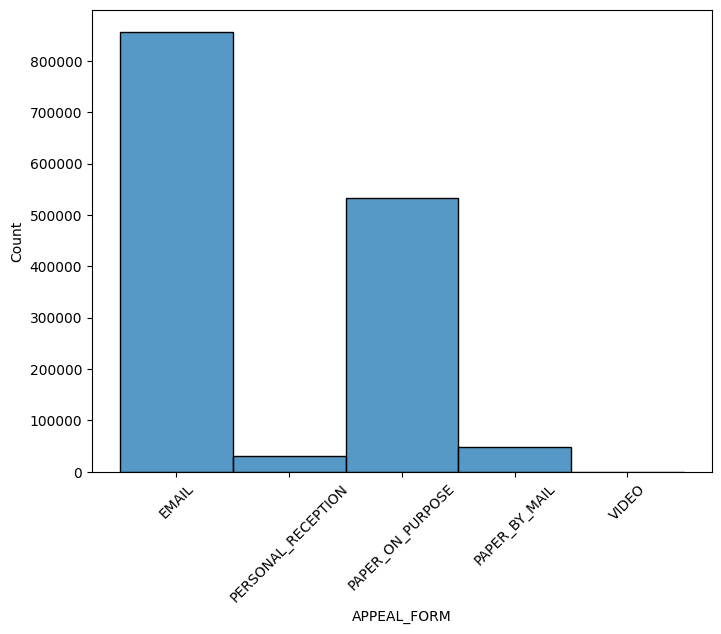

In [34]:
plt.figure(figsize=(8,6))
sns.histplot(data=train_df, 
             x=train_df.APPEAL_FORM, )
plt.xticks(rotation=45)
plt.show()

In [81]:
text_by_appeal_form = test_df.APPEAL_FORM.value_counts()
text_by_appeal_form

APPEAL_FORM
EMAIL                 29112
PAPER_ON_PURPOSE      18278
PAPER_BY_MAIL          1600
PERSONAL_RECEPTION     1006
VIDEO                     4
Name: count, dtype: int64

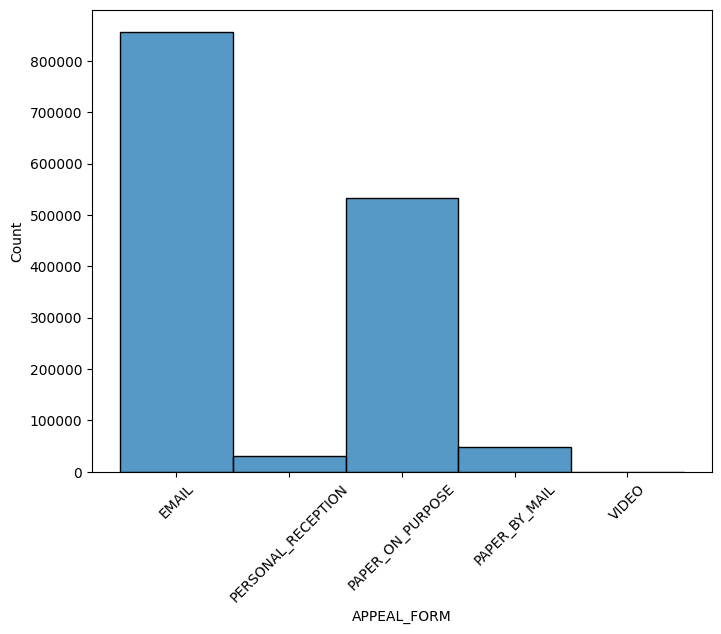

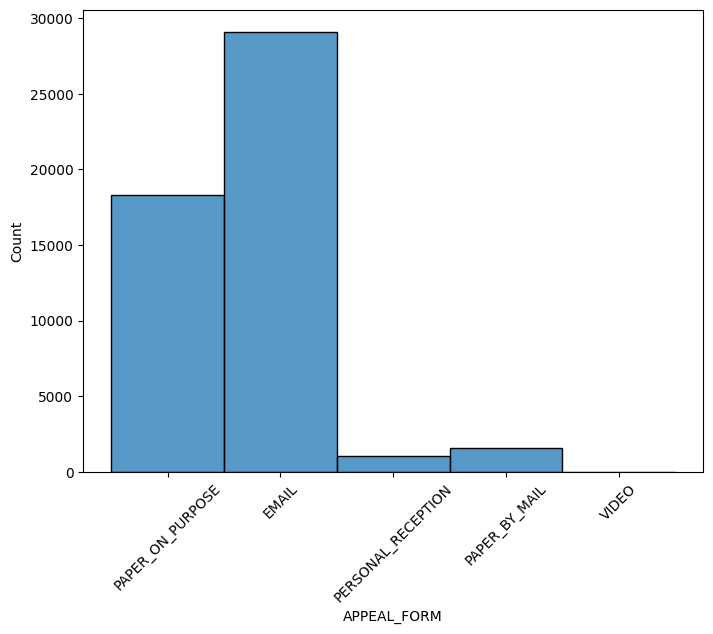

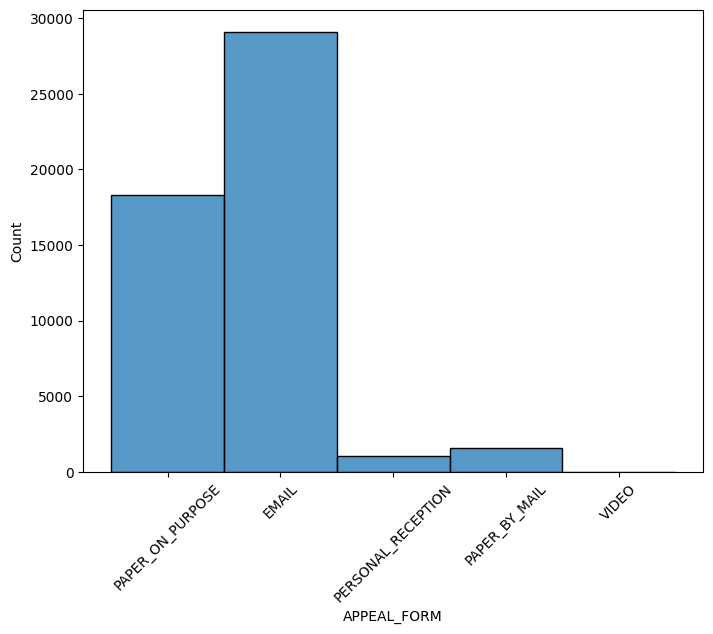

In [33]:
plt.figure(figsize=(8,6))
sns.histplot(data=test_df, 
             x=test_df.APPEAL_FORM, )
plt.xticks(rotation=45)
plt.show()

In [83]:
train_df.LANGUAGE_CODE.value_counts()

LANGUAGE_CODE
2    1161025
1     295133
3      11763
Name: count, dtype: int64

In [84]:
test_df.LANGUAGE_CODE.value_counts()

LANGUAGE_CODE
2    39613
1     9972
3      415
Name: count, dtype: int64

In [85]:
train_df.target.value_counts()

target
178    159086
168     82986
176     54281
194     50212
215     43657
        ...  
399         2
400         2
402         2
374         1
401         1
Name: count, Length: 403, dtype: int64

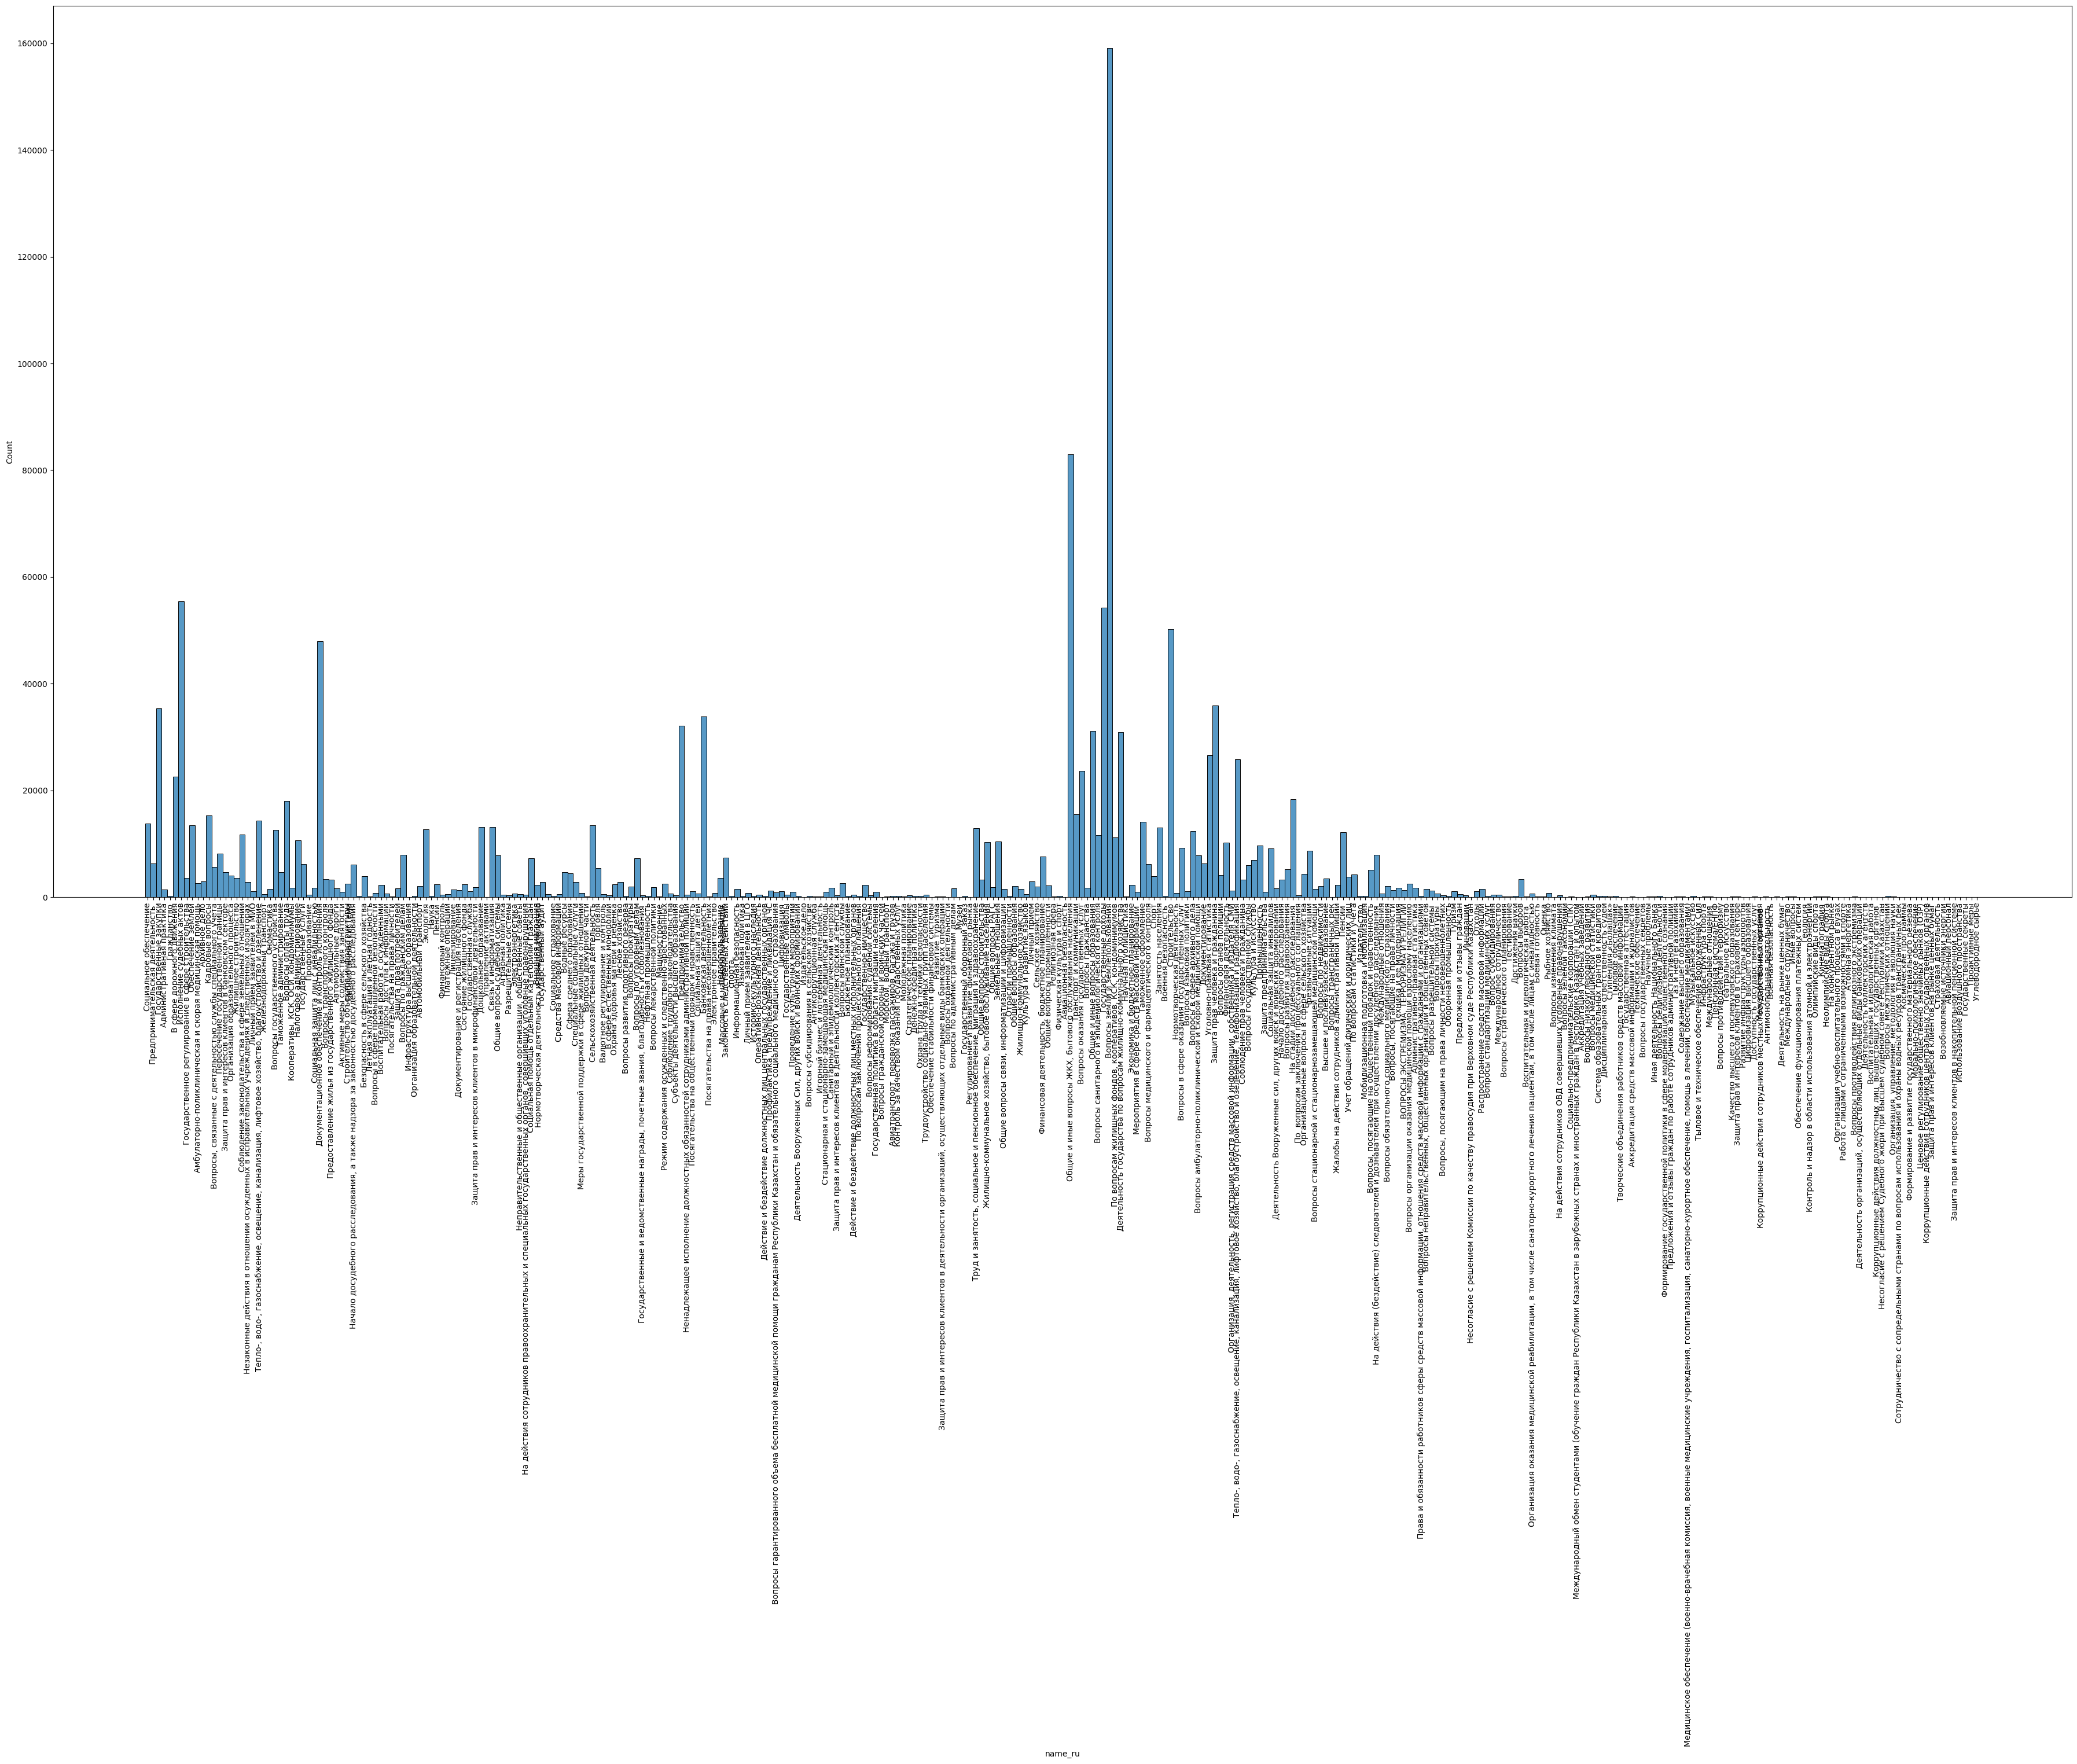

In [37]:
plt.figure(figsize=(45,20))
sns.histplot(data=train_df, 
             x=train_df.name_ru, )
plt.xticks(rotation=90)
plt.show()

In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1467921 entries, 0 to 1467923
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ID             1467921 non-null  int64  
 1   target         1467921 non-null  int64  
 2   DATA           1467921 non-null  object 
 3   LANGUAGE_CODE  1467921 non-null  int64  
 4   APPEAL_FORM    1467921 non-null  object 
 5   ORG_ID         1467921 non-null  int64  
 6   id             1467921 non-null  float64
 7   name_ru        1467921 non-null  object 
 8   name_kk        1467921 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 112.0+ MB


In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             50000 non-null  int64 
 1   DATA           50000 non-null  object
 2   LANGUAGE_CODE  50000 non-null  int64 
 3   APPEAL_FORM    50000 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


In [89]:
dept.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, 0 to 427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       403 non-null    float64
 1   name_ru  403 non-null    object 
 2   name_kk  403 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.6+ KB


In [90]:
org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66553 entries, 0 to 66552
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       66553 non-null  int64 
 1   NAME_RU  66553 non-null  object
 2   NAME_KK  66551 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


## Replace * $ # to keywords

In [5]:
train_df['DATA'] = train_df['DATA'].str.replace(r'\$+', 'СЧЕТ', regex=True)
train_df['DATA'] = train_df['DATA'].str.replace(r'\#+', 'IBAN', regex=True)
train_df['DATA'] = train_df['DATA'].str.replace(r'\*+', 'ИМЯ', regex=True)

test_df['DATA'] = test_df['DATA'].str.replace(r'\$+', 'СЧЕТ', regex=True)
test_df['DATA'] = test_df['DATA'].str.replace(r'\#+', 'IBAN', regex=True)
test_df['DATA'] = test_df['DATA'].str.replace(r'\*+', 'ИМЯ', regex=True)

In [126]:
test_df.DATA

0                                 ИМЯ выдаче копий приказа
1             Адвокатский запрос от 07 11 2022года за №186
2                         ИМЯ выполнение письма по запросу
3        ИМЯ  ИМЯ ИМЯ ИМЯ  являлся сотрудником ИМЯ «Нац...
4        ТОО «Bazis Construction»  пользуясь случаем  в...
                               ...                        
49995    ИМЯ сообщить правомерно ИМЯ решение собрания к...
49996                        Запрос на справку по доходам 
49997          Автокөлікті аресттен шешіп беру туралы арыз
49998    Президенту ИМЯ ИМЯ ИМЯ ИМЯ ИМЯ  ИМЯ Председате...
49999    ИМЯ  ТНК  Казхром  просит признать необоснован...
Name: DATA, Length: 50000, dtype: object

In [6]:
# join train with label names
train_df = pd.merge(train_df, dept, left_on='target', right_on='id')

In [7]:
train_df = train_df.dropna()

In [39]:
# create features on text len
train_df['sym_len'] = train_df.DATA.apply(len)
train_df['word_len'] = train_df.DATA.apply(lambda x: len(x.split()))

test_df['sym_len'] = train_df.DATA.apply(len)
test_df['word_len'] = train_df.DATA.apply(lambda x: len(x.split()))

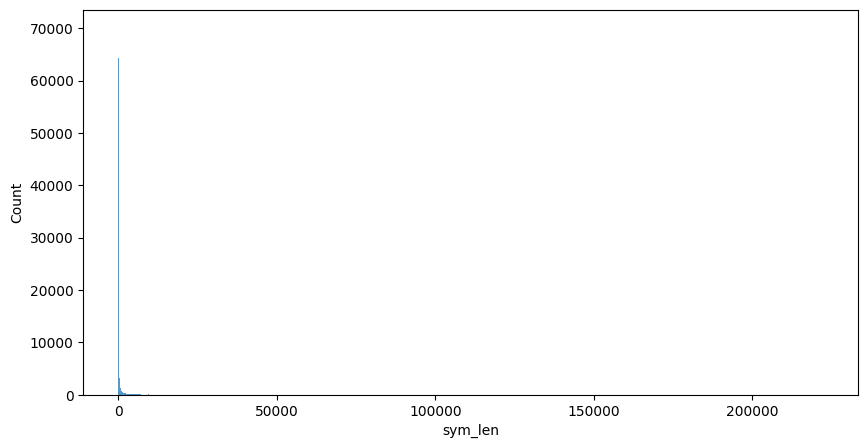

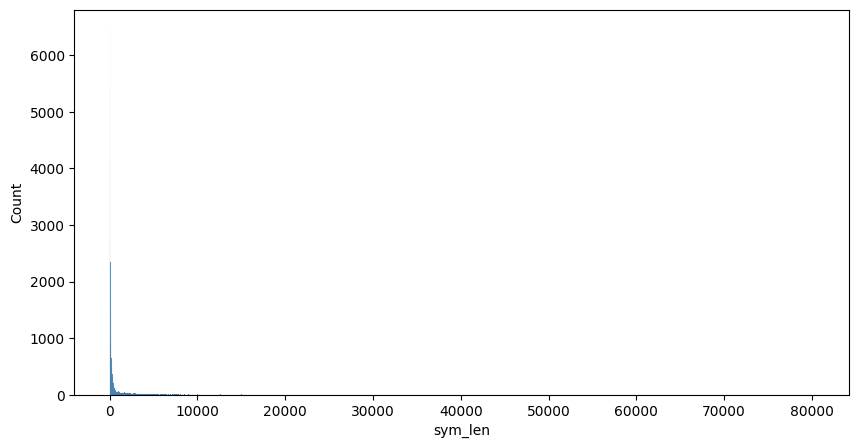

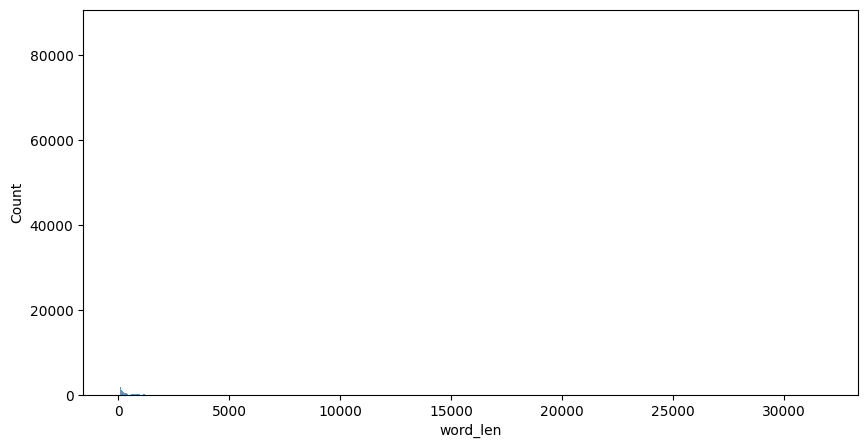

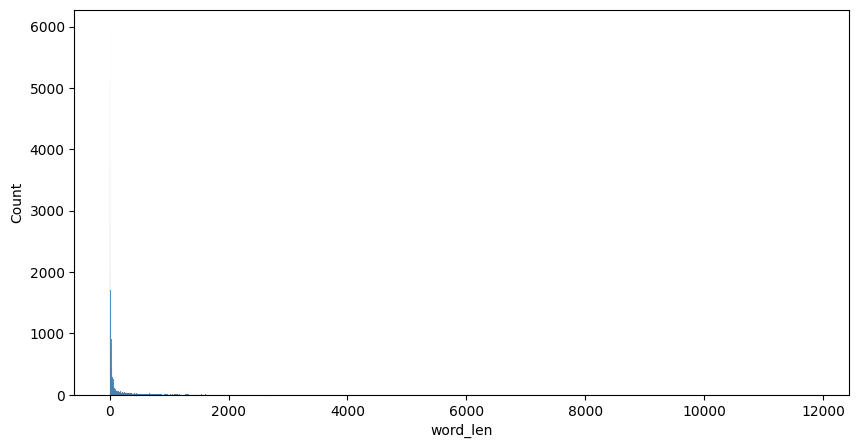

In [40]:
# Long tail distribution

plt.figure(figsize=(10, 5))
sns.histplot(data=train_df.sym_len)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=test_df.sym_len)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=train_df.word_len)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=test_df.word_len)
plt.show()

In [41]:
# therefore need to log
# but before fill zeros with ones to avoid -inf while log
train_df['word_len'] = train_df['word_len'].replace(0, 1)
test_df['word_len'] = test_df['word_len'].replace(0, 1)

train_df['sym_len'] = np.log(train_df['sym_len'])
train_df['word_len'] = np.log(train_df['word_len'])

test_df['sym_len'] = np.log(test_df['sym_len'])
test_df['word_len'] = np.log(test_df['word_len'])

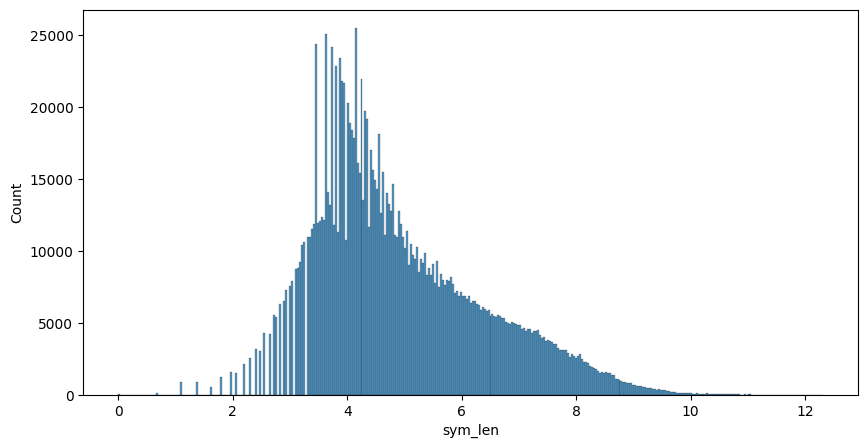

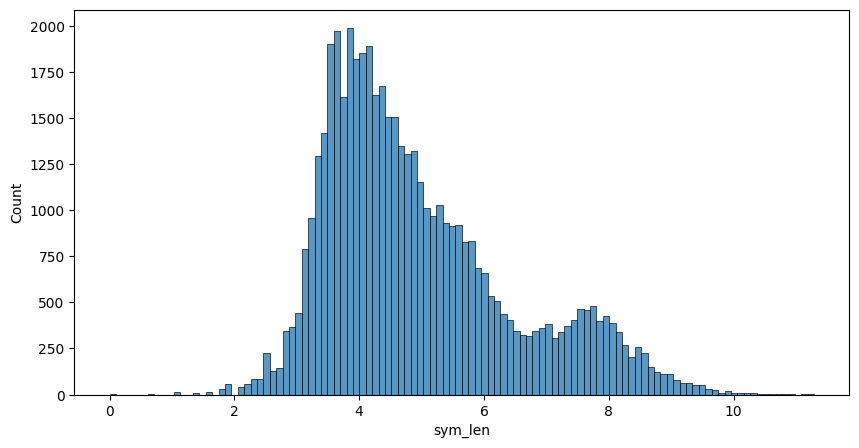

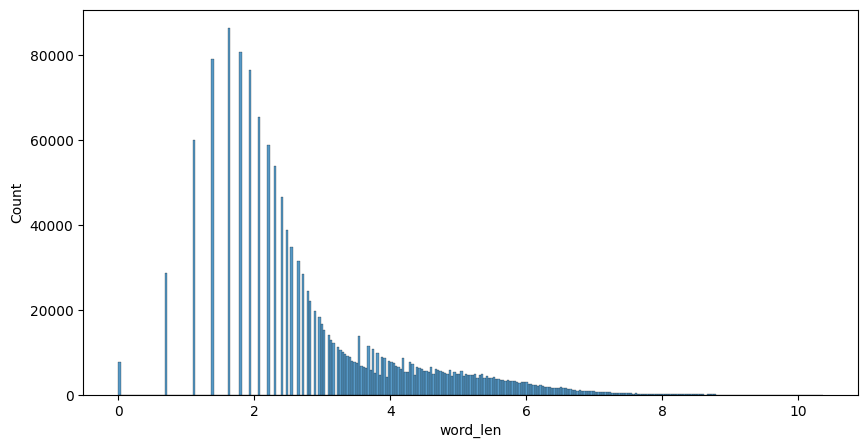

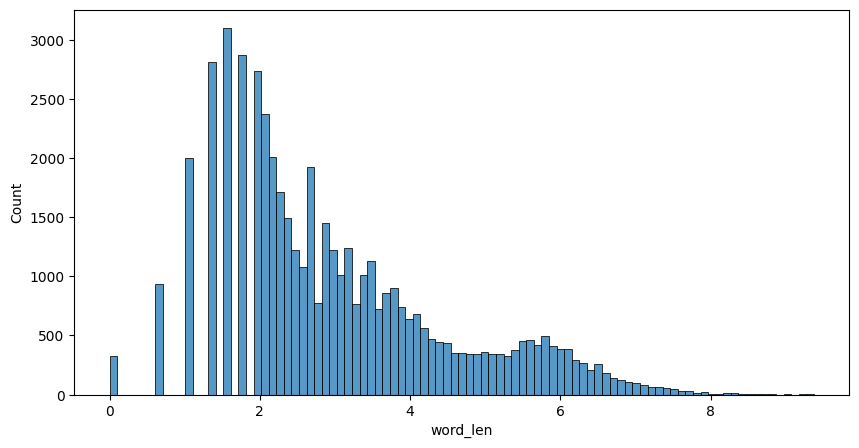

In [42]:
# Long tail distribution

plt.figure(figsize=(10, 5))
sns.histplot(data=train_df.sym_len)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=test_df.sym_len)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=train_df.word_len)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=test_df.word_len)
plt.show()

In [ ]:
# check for non string texts
for l in train_df.DATA:
    if str(type(l)) != "<class 'str'>":
        print(l, type(l))
        
for l in test_df.DATA:
    if str(type(l)) != "<class 'str'>":
        print(l, type(l))

In [ ]:
for l in train_df.DATA:
    if l == "":
        print(l, type(l))
        
for l in test_df.DATA:
    if l == "":
        print(l, type(l))

## Lemmatization (Had no time to use. Planned to translate all the texts to Russian and use Pymorphy2 + Lemmatization)

In [ ]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [ ]:
# parallelize preprocessing # Work In progress
from joblib import Parallel, delayed

lemmas = Parallel(n_jobs=-1)(delayed(clean_text)(t) for t in test_df.head()['DATA'])

In [ ]:
from multiprocessing import Pool as PoolSklearn
with PoolSklearn(10) as p:
    lemmas = list(tqdm(p.imap(clean_text, test_df.head(20)['DATA']), total=len(test_df.head(20))))

In [ ]:
test_df['lemmas'] = lemmas
test_df.sample(20)

## Further data preprocessing

In [10]:
# before splitting remove samples with 3 or less occurences

train_df = train_df.groupby('target').filter(lambda x : len(x) > 3)

In [11]:
# if empty then removal was successful

series = train_df.value_counts('target')
series[series<4]

Series([], Name: count, dtype: int64)

In [12]:
# define X and y

from sklearn.model_selection import train_test_split as tts
train_df.reset_index(drop=True, inplace=True)

df_train_val = train_df[['DATA', 'LANGUAGE_CODE', 'APPEAL_FORM', 'sym_len', 'word_len']]
y_train_val = train_df['target']

X_test = test_df[['DATA', 'LANGUAGE_CODE', 'APPEAL_FORM', 'sym_len', 'word_len']]

## Deal with class imbalance

In [13]:
# undersampling to deal with imbalance
!pip install -U imbalanced-learn


from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train_val, y_train_val)
print(len(X_resampled), len(y_resampled))

1308814 1308814


In [14]:
while len(X_resampled) > 600000:
    X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
    print(len(X_resampled), len(y_resampled))

1225832 1225832
1171555 1171555
1121347 1121347
1077694 1077694
1038366 1038366
1002437 1002437
969546 969546
938443 938443
907552 907552
878632 878632
852003 852003
825436 825436
799623 799623
776000 776000
757730 757730
742158 742158
726704 726704
711558 711558
697202 697202
683113 683113
669662 669662
656451 656451
643470 643470
630614 630614
618307 618307
606114 606114
594298 594298


In [15]:
y_resampled.value_counts()

target
230    11818
17     11696
175    11634
205    11513
253    11458
       ...  
168        4
248        4
150        4
20         4
397        4
Name: count, Length: 392, dtype: int64

In [16]:
X_train, X_val, y_train, y_val = tts(X_resampled, y_resampled, stratify=y_resampled, shuffle=True, train_size=0.999)  

In [18]:
# mljar
!pip install mljar-supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.1 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-1.1.1-py3-none-any.whl size=164977 sha256=ed6a18c6ce619952b502699ca20ee16437d53ea71002edf29750c596ab9edd84
  Stored in directory: /root/.cache/pip/wheels/e3/66/9f/bdde96c1acfe3870621cef302d8e41b5d507a4d940ce7ba16e
Successfully built mljar-supervised
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


In [19]:
# mljar stacking

from supervised import AutoML
automl = AutoML(mode="Compete", eval_metric='f1', ml_task="multiclass_classification", n_jobs=-1, total_time_limit = 3600)
automl.fit(X_train, y_train)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Linear algorithm was disabled.
Disable stacking for split validation
AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric f1
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Neural Network', 'Nearest Neighbors']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 3 models


/opt/conda/lib/python3.10/site-packages/supervised/callbacks/early_stopping.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.10/site-packages/supervised/callbacks/early_stopping.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.10/site-packages/supervised/callbacks/early_stopping.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

1_DecisionTree f1 0.042514 trained in 394.33 seconds


/opt/conda/lib/python3.10/site-packages/supervised/callbacks/early_stopping.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.10/site-packages/supervised/callbacks/early_stopping.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.10/site-packages/supervised/callbacks/early_stopping.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

2_DecisionTree f1 0.047292 trained in 420.05 seconds
Skip default_algorithms because of the time limit.
Skip not_so_random because of the time limit.
Skip mix_encoding because no parameters were generated.
Skip golden_features because no parameters were generated.
'score' Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/supervised/tuner/mljar_tuner.py", line 225, in generate_params
    return self.get_kmeans_features_params(
  File "/opt/conda/lib/python3.10/site-packages/supervised/tuner/mljar_tuner.py", line 1188, in get_kmeans_features_params
    df_models, algorithms = self.df_models_algorithms(
  File "/opt/conda/lib/python3.10/site-packages/supervised/tuner/mljar_tuner.py", line 1113, in df_models_algorithms
    df_models.sort_values(by="score", ascending=True, inplace=True)
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/frame.py", line 6758, in sort_values
    k = self._get_label_or_level_values(by, axis=axis)
  File "/opt/conda/lib

AutoML(eval_metric='f1', ml_task='multiclass_classification', mode='Compete',
       total_time_limit=1000)

In [20]:
y_pred = automl.predict(X_val)

In [21]:
y_pred

array([207, 218, 207, 207, 207, 207, 218, 253, 207, 179, 205, 207, 207,
       253, 207, 207, 218, 205, 179, 205, 218, 179, 207, 205, 207, 205,
       207, 207, 207, 207, 205, 253, 207, 253, 207, 205, 207, 207, 207,
       207, 207, 207, 205, 207, 205, 207, 207, 253, 207, 205, 207, 207,
       218, 207,  27, 207, 205, 207, 218, 205, 207, 207, 207, 218, 253,
       253, 253,  27, 253, 218, 207, 207, 207, 253, 207, 207, 207, 207,
       207, 253, 275, 207, 207, 207, 207,  27, 207, 207, 207, 207, 253,
       253, 207, 253, 207, 207, 207, 218, 179,  27, 253, 207, 207, 207,
       218, 253, 207, 207, 207, 205, 207, 207, 218, 253, 253, 253, 179,
       253, 218,  27, 207, 253, 207, 207, 207, 207, 207, 253, 207, 253,
       207, 207, 207, 207, 253, 207, 207, 207, 207, 253, 207, 253, 253,
       253, 205, 207, 207, 253, 205, 207, 179, 207, 207, 205, 179,  17,
       207, 207, 207, 207, 207, 253, 207, 207, 253, 207, 207, 253, 207,
       207, 207,  27, 207, 179, 207, 207, 207, 207, 207, 253,  1

In [22]:
from sklearn.metrics import f1_score
f1_score(y_val.values, y_pred, average='macro')

0.00964482653314489

## Inference

In [23]:
X_test = test_df[['DATA', 'LANGUAGE_CODE', 'APPEAL_FORM', 'sym_len', 'word_len']]

In [24]:
y_pred = automl.predict(X_test)

In [25]:
y_pred

array([205, 207, 207, ..., 207,  27, 207])

In [26]:
# submission
submission = pd.DataFrame({'ID': test_df.ID,
                           'target': y_pred})
submission

,ID,target
0,21122201109556,205
1,22110702727060,207
2,22100502546017,207
3,22101102578159,207
4,22051201734764,253
...,...,...
49995,22083102347735,207
49996,23020600207807,207
49997,23022300336156,207
49998,23021400270566,27


In [27]:
submission.to_csv('submission.csv', index=False)

## Feature importance

In [28]:
#WIP